<a href="https://colab.research.google.com/github/KeletsoM/JHB_Group_15_Sendy/blob/master/JHB_15_Sendy_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sendy Logistics report

## Background

## Objectives

1. Data Sourcing 
2. Data Cleaning 
3. EDA
4. Pre-processing 
5. Training and Validation  
6. Model Evaluation
7. Recommendations
8. Acquire an RMSE score of 780 or less


## Data cleaning

The raw data received from Sendy was has redundant and information that is not useful to predicting the Time from Pickup to Arrival. We therefore have to get rid of those particular data. Some of the data also needs to be transormed or converted to more useful information.

### Column Deletion
Firstly we need to get rid of useless and a redundant data the following is a list of all the columns that are going to be ommitted:

- <b>Order_ID</b>: this column carries no numerical or categorical significance, each entry is unique and has absolutely no bearing in predicting the Time from Pickup to Arrival.
- <b>User_ID</b>: the User_ID has no significance in our prediction because for our model we are assuming that Sendy does not discriminate or prioritise certain individuals.
- <b>Vehicle Types</b>: this column is going to be ommited because all the riders use a bike as their main form of transport.
- <b>Precipitation in millimeters</b>: this collumn has too much missing data 

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
Train = pd.read_csv('Train.csv')
Test = pd.read_csv('Test.csv')
Riders = pd.read_csv('Riders.csv')
Train.head()

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


,Order No,User Id,Vehicle Type,Platform Type,Personal or Business,Placement - Day of Month,Placement - Weekday (Mo = 1),Placement - Time,Confirmation - Day of Month,Confirmation - Weekday (Mo = 1),Confirmation - Time,Arrival at Pickup - Day of Month,Arrival at Pickup - Weekday (Mo = 1),Arrival at Pickup - Time,Pickup - Day of Month,Pickup - Weekday (Mo = 1),Pickup - Time,Arrival at Destination - Day of Month,Arrival at Destination - Weekday (Mo = 1),Arrival at Destination - Time,Distance (KM),Temperature,Precipitation in millimeters,Pickup Lat,Pickup Long,Destination Lat,Destination Long,Rider Id,Time from Pickup to Arrival
0,Order_No_4211,User_Id_633,Bike,3,Business,9,5,9:35:46 AM,9,5,9:40:10 AM,9,5,10:04:47 AM,9,5,10:27:30 AM,9,5,10:39:55 AM,4,20.4,NaN,-1.317755,36.830370,-1.300406,36.829741,Rider_Id_432,745
1,Order_No_25375,User_Id_2285,Bike,3,Personal,12,5,11:16:16 AM,12,5,11:23:21 AM,12,5,11:40:22 AM,12,5,11:44:09 AM,12,5,12:17:22 PM,16,26.4,NaN,-1.351453,36.899315,-1.295004,36.814358,Rider_Id_856,1993
2,Order_No_1899,User_Id_265,Bike,3,Business,30,2,12:39:25 PM,30,2,12:42:44 PM,30,2,12:49:34 PM,30,2,12:53:03 PM,30,2,1:00:38 PM,3,NaN,NaN,-1.308284,36.843419,-1.300921,36.828195,Rider_Id_155,455
3,Order_No_9336,User_Id_1402,Bike,3,Business,15,5,9:25:34 AM,15,5,9:26:05 AM,15,5,9:37:56 AM,15,5,9:43:06 AM,15,5,10:05:27 AM,9,19.2,NaN,-1.281301,36.832396,-1.257147,36.795063,Rider_Id_855,1341
4,Order_No_27883,User_Id_1737,Bike,1,Personal,13,1,9:55:18 AM,13,1,9:56:18 AM,13,1,10:03:53 AM,13,1,10:05:23 AM,13,1,10:25:37 AM,9,15.4,NaN,-1.266597,36.792118,-1.295041,36.809817,Rider_Id_770,1214


In [0]:
Train.drop(['Order No','User Id','Vehicle Type','Precipitation in millimeters'], axis=1, inplace=True)

From the table above we can observe that the all the deliveries that were provided in the dataset are all same day deliveries therefore having the following columns in our dataset would be redundant:

- Placement - Day of Month
- Placement - Weekday (Mo = 1)
- Confirmation - Day of Month
- Confirmation - Weekday (Mo = 1)
- Arrival at Pickup - Day of Month
- Arrival at Pickup - Weekday (Mo = 1)
- Arrival at Destination - Weekday (Mo = 1)

The approach is to keep 2 of the columns one for week day and for day of the month and delete the rest of the columns, but first we need to  confirm if they are equal.

In [0]:
Train.drop(['Confirmation - Day of Month','Confirmation - Weekday (Mo = 1)','Arrival at Pickup - Day of Month',
            'Arrival at Pickup - Weekday (Mo = 1)','Arrival at Destination - Weekday (Mo = 1)','Pickup - Day of Month',
            'Pickup - Weekday (Mo = 1)','Arrival at Destination - Day of Month'], axis=1, inplace=True)

### Cleaning Test data

For our model to produce accurate results we need to also clean the test data the same way we clean the train data we need to ensure that what ever columns we drop in the train we also drop in the test.

In [0]:
Test.drop(['Order No','User Id','Vehicle Type','Precipitation in millimeters'], axis=1, inplace=True)

In [0]:
Test.drop(['Confirmation - Day of Month','Confirmation - Weekday (Mo = 1)','Arrival at Pickup - Day of Month',
            'Arrival at Pickup - Weekday (Mo = 1)','Pickup - Day of Month',
            'Pickup - Weekday (Mo = 1)','Temperature'], axis=1, inplace=True)

## Exploratory Data analysis

In [0]:
Train.head()

,Order No,User Id,Vehicle Type,Platform Type,Personal or Business,Placement - Day of Month,Placement - Weekday (Mo = 1),Placement - Time,Confirmation - Day of Month,Confirmation - Weekday (Mo = 1),Confirmation - Time,Arrival at Pickup - Day of Month,Arrival at Pickup - Weekday (Mo = 1),Arrival at Pickup - Time,Pickup - Day of Month,Pickup - Weekday (Mo = 1),Pickup - Time,Arrival at Destination - Day of Month,Arrival at Destination - Weekday (Mo = 1),Arrival at Destination - Time,Distance (KM),Temperature,Precipitation in millimeters,Pickup Lat,Pickup Long,Destination Lat,Destination Long,Rider Id,Time from Pickup to Arrival
0,Order_No_4211,User_Id_633,Bike,3.0,Business,9.0,5.0,9:35:46 AM,9.0,5.0,9:40:10 AM,9.0,5.0,10:04:47 AM,9.0,5.0,10:27:30 AM,9.0,5.0,10:39:55 AM,4.0,20.4,NaN,-1.317755,36.830370,-1.300406,36.829741,Rider_Id_432,745.0
1,Order_No_25375,User_Id_2285,Bike,3.0,Personal,12.0,5.0,11:16:16 AM,12.0,5.0,11:23:21 AM,12.0,5.0,11:40:22 AM,12.0,5.0,11:44:09 AM,12.0,5.0,12:17:22 PM,16.0,26.4,NaN,-1.351453,36.899315,-1.295004,36.814358,Rider_Id_856,1993.0
2,Order_No_1899,User_Id_265,Bike,3.0,Business,30.0,2.0,12:39:25 PM,30.0,2.0,12:42:44 PM,30.0,2.0,12:49:34 PM,30.0,2.0,12:53:03 PM,30.0,2.0,1:00:38 PM,3.0,NaN,NaN,-1.308284,36.843419,-1.300921,36.828195,Rider_Id_155,455.0
3,Order_No_9336,User_Id_1402,Bike,3.0,Business,15.0,5.0,9:25:34 AM,15.0,5.0,9:26:05 AM,15.0,5.0,9:37:56 AM,15.0,5.0,9:43:06 AM,15.0,5.0,10:05:27 AM,9.0,19.2,NaN,-1.281301,36.832396,-1.257147,36.795063,Rider_Id_855,1341.0
4,Order_No_27883,User_Id_1737,Bike,1.0,Personal,13.0,1.0,9:55:18 AM,13.0,1.0,9:56:18 AM,13.0,1.0,10:03:53 AM,13.0,1.0,10:05:23 AM,13.0,1.0,10:25:37 AM,9.0,15.4,NaN,-1.266597,36.792118,-1.295041,36.809817,Rider_Id_770,1214.0


### Joint plot 

The following plot is a jointplot which plots the scatter plot of the distance vs Time from pickup to Arival of the Sendy data set. The hex function is used to show the concerntration of most data points in order to bring out the underlying trend within the data.

As we can see in the dataset there is some form of linearity between the 2 variables.

<Figure size 720x432 with 0 Axes>

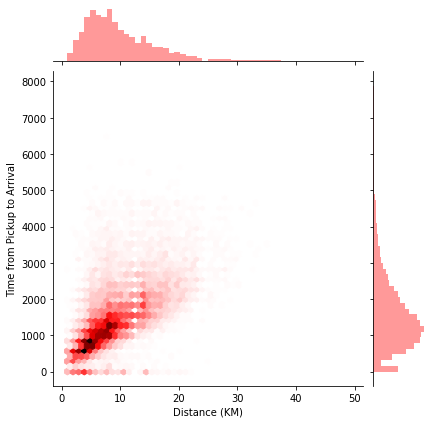

In [0]:
plt.figure(figsize=(10,6))
sns.jointplot(x = 'Distance (KM)', y = 'Time from Pickup to Arrival', data = Train, kind= 'hex', color = 'r')

## A Violin plot the platform type and the Time from pick up to arival

The boxplot below indicates that the the 4th platform is slower than the rest of the other platforms, it also has a wide distribution as well.
The platforms 1,2 and 3 are typically faster than platform 4 but they have a lot of outliars which may pull the mean up, most of the data for platforms 1,2 and 3 lie between 0 to 2000s which is approximately 56min.

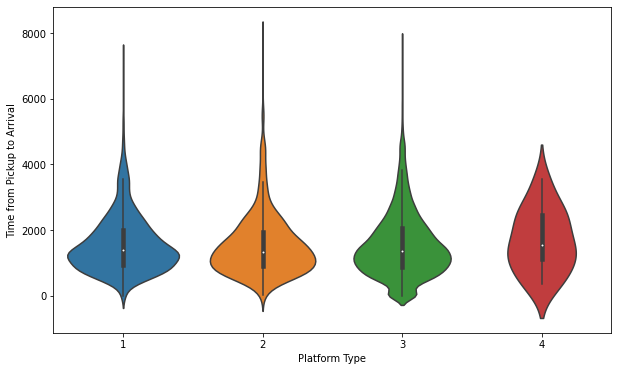

In [0]:
plt.figure(figsize=(10,6))
sns.violinplot(x= 'Platform Type', y = 'Time from Pickup to Arrival', data = Train)

### Violin plot for business or personal deliveries

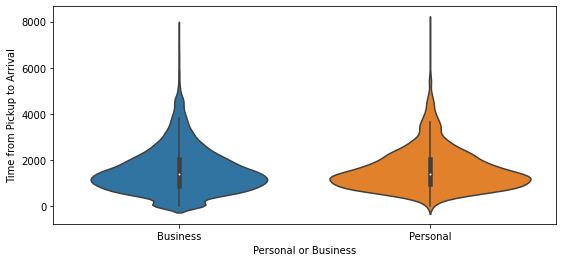

In [68]:
plt.figure(figsize=(9,4))
sns.violinplot(x= 'Personal or Business', y = 'Time from Pickup to Arrival', data = Train)


### Regression plot of the Average rating and the time from pick up to arrival

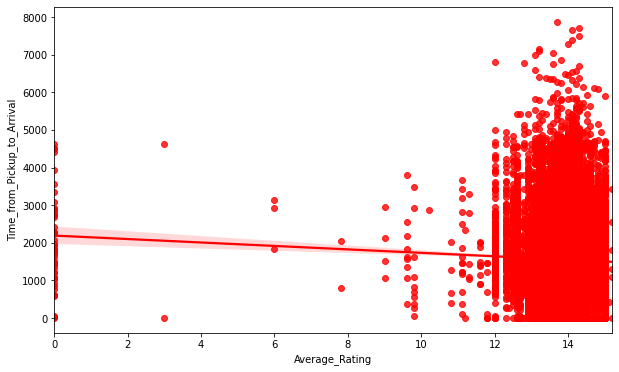

In [70]:
plt.figure(figsize=(10,6))
sns.regplot(combined['Average_Rating'],combined['Time_from_Pickup_to_Arrival'], color = 'red')

The regression plot above indicates that there exists a slight relatonship between the two variables which can be intepreted the following way: the better the riders rating the faster a customer receives their order.

## Feature Engineering

### Transforming coordinates

Data like the coordinates  for the pickup and the destination might look useless but they would be useful if they were transformed into names of cities and therefore we might get insights on how factors like trafic and navigation can impact the time from the pickup  to arrival. The process of converting coordinates into meaningful categorical data is refered to as reverse geocoding.

The reverse_geocoding library will be used to transform the data, before we can transform the coordinates we need to prepare the data by combining the the latitude and longitude values into tuples.

In [0]:
pickup_co= Train[['Pickup Lat', 'Pickup Long']].apply(tuple, axis=1).tolist()
destination_co = Train[['Destination Lat', 'Destination Long']].apply(tuple, axis=1).tolist()

Next we use the reverse_geocoding library to convert the coordinates into city names.

In [0]:
!pip install reverse_geocoder

     |████████████████████████████████| 2.3MB 2.8MB/s 
  Created wheel for reverse-geocoder: filename=reverse_geocoder-1.5.1-cp36-none-any.whl size=2268091 sha256=65fc654181f555c1dd97fd1a82532f97bd2e63b5a915483d5af9ba9fc1592fb4
  Stored in directory: /root/.cache/pip/wheels/47/05/50/b1350ff094ef91e082665b4a2f9ca551f8acea4aa55d796b26
Successfully built reverse-geocoder


In [0]:
import reverse_geocoder as rg

pickup_re = rg.search(pickup_co, mode=2)
Train['Pickup_city'] = [x['name'] for x in pickup_re]

dest_re = rg.search(destination_co, mode=2)
Train['Destination_city'] = [x['name'] for x in dest_re]

Loading formatted geocoded file...


In [0]:
Train['Pickup_to_Destination']= Train[['Pickup_city', 'Destination_city']].agg('-'.join, axis=1)

In [0]:
Train.drop(['Pickup Lat','Pickup Long','Destination Lat','Destination Long',
            'Pickup_city','Destination_city'], axis=1, inplace=True)

In [0]:
pickup_coo= Test[['Pickup Lat', 'Pickup Long']].apply(tuple, axis=1).tolist()
destination_coo = Test[['Destination Lat', 'Destination Long']].apply(tuple, axis=1).tolist()

In [0]:
pickup_ree = rg.search(pickup_coo, mode=2)
Test['Pickup_city'] = [x['name'] for x in pickup_ree]

dest_ree = rg.search(destination_coo, mode=2)
Test['Destination_city'] = [x['name'] for x in dest_ree]

Test['Pickup_to_Destination']= Test[['Pickup_city', 'Destination_city']].agg('-'.join, axis=1)

Test.drop(['Pickup Lat','Pickup Long','Destination Lat','Destination Long',
           'Pickup_city','Destination_city'], axis=1, inplace=True)

### Transforming time to seconds


In [0]:
#converting time into seconds
def time_to_seconds(column_name):
    Train[column_name] = pd.to_datetime(Train[column_name])
    return (Train[column_name]- pd.to_datetime(pd.to_datetime('today').date())).astype('timedelta64[s]')


In [0]:
Train['Confirmation - Time']=time_to_seconds('Confirmation - Time')

In [0]:
Train['Con_Time_of_day'] = ['Morning' if x< 43200 else 'Afternoon' for x in Train['Confirmation - Time']]
Train['Platform Type'] = ['Busy' if x == 3  else 'Not_busy' for x in Train['Platform Type']]

In [0]:
Train.drop(['Placement - Time','Confirmation - Time','Arrival at Pickup - Time','Pickup - Time',
            'Arrival at Destination - Time'], axis=1, inplace=True)

In [0]:
def time_to_seconds1(column_name):
    Test[column_name] = pd.to_datetime(Test[column_name])
    return (Test[column_name]- pd.to_datetime(pd.to_datetime('today').date())).astype('timedelta64[s]')


Test['Confirmation - Time']=time_to_seconds1('Confirmation - Time')
Test['Con_Time_of_day'] = ['Morning' if x< 43200 else 'Afternoon' for x in Test['Confirmation - Time']]
Test['Platform Type'] = ['Busy' if x == 3  else 'Not_busy' for x in Test['Platform Type']]
Test.drop(['Placement - Time','Confirmation - Time','Arrival at Pickup - Time','Pickup - Time'], axis=1, inplace=True)

## Data Pre-processing

In order to carry out the regression model we have to first prepare all the inputs for that model. One requirement of the regression models is that all the inputs must be numerical. Therefore all of the categorical data must be converted into numerical data, we do this by utilizing the onehot encoding in the pd.get_dummies() method. In order for there to be consistency in the variables the the Test data and the Train data need to be combined but at the same time kept separate, we do this by introducing a "train" column for both datasets so that we are able to distinguish the 2 datasets.

In [0]:
Train['train'] = 1
Test['train'] = 0

In [0]:
combined = pd.concat([Train,Test])
combined = combined.merge(Riders, how='left', on = 'Rider Id')

In [0]:
combined.head()

,Platform Type,Personal or Business,Placement - Day of Month,Placement - Weekday (Mo = 1),Distance (KM),Temperature,Rider Id,Time from Pickup to Arrival,Pickup_to_Destination,Con_Time_of_day,train,No_Of_Orders,Age,Average_Rating,No_of_Ratings
0,Busy,Business,9,5,4,20.4,Rider_Id_432,745.0,Nairobi-Nairobi,Morning,1,1637,1309,13.8,549
1,Busy,Personal,12,5,16,26.4,Rider_Id_856,1993.0,Pumwani-Nairobi,Morning,1,396,339,13.6,69
2,Busy,Business,30,2,3,NaN,Rider_Id_155,455.0,Pumwani-Nairobi,Afternoon,1,1023,242,12.5,114
3,Busy,Business,15,5,9,19.2,Rider_Id_855,1341.0,Nairobi-Nairobi,Morning,1,886,283,14.5,113
4,Not_busy,Personal,13,1,9,15.4,Rider_Id_770,1214.0,Nairobi-Nairobi,Morning,1,2311,872,14.1,533


In [0]:
combined = combined[['Platform Type', 'Distance (KM)', 'Rider Id','Personal or Business','Pickup_to_Destination',
                     'Con_Time_of_day','Placement - Day of Month',
                     'Placement - Weekday (Mo = 1)','Average_Rating','train','Time from Pickup to Arrival']]

In [0]:
combined.columns = [col.replace(' ','_') for col in combined.columns]
combined.columns = [col.replace('(','') for col in combined.columns]
combined.columns = [col.replace(')','') for col in combined.columns]

In [0]:
df_dummies = pd.get_dummies(combined,columns=['Platform_Type','Rider_Id','Pickup_to_Destination',
                                              'Con_Time_of_day','Placement_-_Day_of_Month',
                                              'Placement_-_Weekday_Mo_=_1','Personal_or_Business'], drop_first=True)

In [0]:
df_dummies.head()

,Distance_KM,Average_Rating,train,Time_from_Pickup_to_Arrival,Platform_Type_Not_busy,Rider_Id_Rider_Id_1,Rider_Id_Rider_Id_10,Rider_Id_Rider_Id_100,Rider_Id_Rider_Id_101,Rider_Id_Rider_Id_102,Rider_Id_Rider_Id_103,Rider_Id_Rider_Id_104,Rider_Id_Rider_Id_105,Rider_Id_Rider_Id_106,Rider_Id_Rider_Id_107,Rider_Id_Rider_Id_108,Rider_Id_Rider_Id_109,Rider_Id_Rider_Id_11,Rider_Id_Rider_Id_110,Rider_Id_Rider_Id_111,Rider_Id_Rider_Id_112,Rider_Id_Rider_Id_113,Rider_Id_Rider_Id_114,Rider_Id_Rider_Id_115,Rider_Id_Rider_Id_116,Rider_Id_Rider_Id_117,Rider_Id_Rider_Id_118,Rider_Id_Rider_Id_119,Rider_Id_Rider_Id_12,Rider_Id_Rider_Id_120,Rider_Id_Rider_Id_121,Rider_Id_Rider_Id_122,Rider_Id_Rider_Id_123,Rider_Id_Rider_Id_124,Rider_Id_Rider_Id_125,Rider_Id_Rider_Id_126,Rider_Id_Rider_Id_127,Rider_Id_Rider_Id_128,Rider_Id_Rider_Id_129,Rider_Id_Rider_Id_13,...,Pickup_to_Destination_Pumwani-Pumwani,Pickup_to_Destination_Pumwani-Thika,Con_Time_of_day_Morning,Placement_-_Day_of_Month_2,Placement_-_Day_of_Month_3,Placement_-_Day_of_Month_4,Placement_-_Day_of_Month_5,Placement_-_Day_of_Month_6,Placement_-_Day_of_Month_7,Placement_-_Day_of_Month_8,Placement_-_Day_of_Month_9,Placement_-_Day_of_Month_10,Placement_-_Day_of_Month_11,Placement_-_Day_of_Month_12,Placement_-_Day_of_Month_13,Placement_-_Day_of_Month_14,Placement_-_Day_of_Month_15,Placement_-_Day_of_Month_16,Placement_-_Day_of_Month_17,Placement_-_Day_of_Month_18,Placement_-_Day_of_Month_19,Placement_-_Day_of_Month_20,Placement_-_Day_of_Month_21,Placement_-_Day_of_Month_22,Placement_-_Day_of_Month_23,Placement_-_Day_of_Month_24,Placement_-_Day_of_Month_25,Placement_-_Day_of_Month_26,Placement_-_Day_of_Month_27,Placement_-_Day_of_Month_28,Placement_-_Day_of_Month_29,Placement_-_Day_of_Month_30,Placement_-_Day_of_Month_31,Placement_-_Weekday_Mo_=_1_2,Placement_-_Weekday_Mo_=_1_3,Placement_-_Weekday_Mo_=_1_4,Placement_-_Weekday_Mo_=_1_5,Placement_-_Weekday_Mo_=_1_6,Placement_-_Weekday_Mo_=_1_7,Personal_or_Business_Personal
0,4,13.8,1,745.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1,16,13.6,1,1993.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1
2,3,12.5,1,455.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0
3,9,14.5,1,1341.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
4,9,14.1,1,1214.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [0]:
Test2 = df_dummies[df_dummies['train']== 0]
Test2.drop(['train'],axis=1,inplace=True)

Train2 = df_dummies[df_dummies['train']==1]
Train2.drop(['train'],axis=1, inplace=True)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [0]:
Test2.drop(['Time_from_Pickup_to_Arrival'], axis=1,inplace=True)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [0]:
Test2

,Distance_KM,Average_Rating,Platform_Type_Not_busy,Rider_Id_Rider_Id_1,Rider_Id_Rider_Id_10,Rider_Id_Rider_Id_100,Rider_Id_Rider_Id_101,Rider_Id_Rider_Id_102,Rider_Id_Rider_Id_103,Rider_Id_Rider_Id_104,Rider_Id_Rider_Id_105,Rider_Id_Rider_Id_106,Rider_Id_Rider_Id_107,Rider_Id_Rider_Id_108,Rider_Id_Rider_Id_109,Rider_Id_Rider_Id_11,Rider_Id_Rider_Id_110,Rider_Id_Rider_Id_111,Rider_Id_Rider_Id_112,Rider_Id_Rider_Id_113,Rider_Id_Rider_Id_114,Rider_Id_Rider_Id_115,Rider_Id_Rider_Id_116,Rider_Id_Rider_Id_117,Rider_Id_Rider_Id_118,Rider_Id_Rider_Id_119,Rider_Id_Rider_Id_12,Rider_Id_Rider_Id_120,Rider_Id_Rider_Id_121,Rider_Id_Rider_Id_122,Rider_Id_Rider_Id_123,Rider_Id_Rider_Id_124,Rider_Id_Rider_Id_125,Rider_Id_Rider_Id_126,Rider_Id_Rider_Id_127,Rider_Id_Rider_Id_128,Rider_Id_Rider_Id_129,Rider_Id_Rider_Id_13,Rider_Id_Rider_Id_130,Rider_Id_Rider_Id_131,...,Pickup_to_Destination_Pumwani-Pumwani,Pickup_to_Destination_Pumwani-Thika,Con_Time_of_day_Morning,Placement_-_Day_of_Month_2,Placement_-_Day_of_Month_3,Placement_-_Day_of_Month_4,Placement_-_Day_of_Month_5,Placement_-_Day_of_Month_6,Placement_-_Day_of_Month_7,Placement_-_Day_of_Month_8,Placement_-_Day_of_Month_9,Placement_-_Day_of_Month_10,Placement_-_Day_of_Month_11,Placement_-_Day_of_Month_12,Placement_-_Day_of_Month_13,Placement_-_Day_of_Month_14,Placement_-_Day_of_Month_15,Placement_-_Day_of_Month_16,Placement_-_Day_of_Month_17,Placement_-_Day_of_Month_18,Placement_-_Day_of_Month_19,Placement_-_Day_of_Month_20,Placement_-_Day_of_Month_21,Placement_-_Day_of_Month_22,Placement_-_Day_of_Month_23,Placement_-_Day_of_Month_24,Placement_-_Day_of_Month_25,Placement_-_Day_of_Month_26,Placement_-_Day_of_Month_27,Placement_-_Day_of_Month_28,Placement_-_Day_of_Month_29,Placement_-_Day_of_Month_30,Placement_-_Day_of_Month_31,Placement_-_Weekday_Mo_=_1_2,Placement_-_Weekday_Mo_=_1_3,Placement_-_Weekday_Mo_=_1_4,Placement_-_Weekday_Mo_=_1_5,Placement_-_Weekday_Mo_=_1_6,Placement_-_Weekday_Mo_=_1_7,Personal_or_Business_Personal
21201,-0.265757,-0.635904,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0
21202,-0.794967,0.564904,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
21203,-0.794967,-0.854233,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0
21204,-0.794967,-0.199247,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
21205,-0.618564,0.237411,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28264,-0.794967,-0.854233,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
28265,2.203889,0.019082,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
28266,0.087049,-0.199247,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
28267,1.498275,0.237411,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1


In [0]:
column_titles = [col for col in Train2.columns if col !=
                 'Time_from_Pickup_to_Arrival'] + ['Time_from_Pickup_to_Arrival']
Train3 = Train2.reindex(columns=column_titles)

## Models that were implemented

In this section the models that were implemented and that assisted us to get to the final model will be discussed these models are also attached to the appendix folder in the github repository. 

- The first model which we applied is a simple multiple linear regression model we chose this model because from the EDA we had observed a linear relationship between the distance and the Time_from_Pickup_to_arrival therefore. We then also a observed that the average rating and the dependent variable also have a corelation. It was then decided that the distance and the Rider ID were going to be our features for the first model. The combination of the features then resulted in an RMSE score of 756.

- We then tried a ridge regression model model whereby we added the following features: platform type, RiderID and Distance, these features then gave us an RSME Score of 751. Notebook name: Ridge Regression predict MK_1

- Our next ridge regression we transformed the coordinates to city names and added the day of the month and the day of the week to our features which then gave us a score of 745.
Notebook name: Ridge Regression predict MK_2





## Model Implementation

After experimenting a bit we came across another linear model called the Bayesion ridge regression model with is a model which proved to be more accurate it reduced our RMSE score from 745 to 739 which is quite efficient. The bayesian linear regression makes use of Bayes theorem. Rather than formulating a model ny using point estimates (like multiple linear regression and ridge regression) the bayesian ridge uses the probability distrbutions to formulate the linear regression. 

The aim of Bayesian is not to attain a single best value for the features but to determine the posterior distribution that govern the model parameters, this achieved by applying conditional probability (Bayes theorem) to the training inputs and outputs.



In [0]:
from sklearn.linear_model import BayesianRidge
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [0]:
x = Train3.iloc[:,:-1]
y = Train3.iloc[:,-1]

#### Feature Scaling

Feature scaling has been implemented on the columns Distance_KM and the average rating column in order to have the values on the same scale.

In [0]:
scaler = StandardScaler()
x.iloc[:,:2] = scaler.fit_transform(x.iloc[:,:2])

### Train and 'Test' (validation) split

The test data received from Zindi is not labelled only the train data is labelled therefore in order to evaluate the performance of our we will need to split the Train data into a train and a validation dataset. The test and validation will help us to make adjustments to our features. 

In [0]:
X_train, X_test, y_train, y_test = train_test_split(x, 
                                                    y, 
                                                    test_size=0.2, 
                                                    shuffle=False)

## Training the model with a Bayesian Ridge regression



In [0]:
reg = BayesianRidge()
reg.fit(X_train, y_train)

BayesianRidge(alpha_1=1e-06, alpha_2=1e-06, alpha_init=None,
              compute_score=False, copy_X=True, fit_intercept=True,
              lambda_1=1e-06, lambda_2=1e-06, lambda_init=None, n_iter=300,
              normalize=False, tol=0.001, verbose=False)

In [0]:
train_boost = reg.predict(X_train)
test_boost = reg.predict(X_test)

## Model evaluation 

The Root Mean squared error is a measure of quality of a linear regression, it is the sum the squared sum of the difference between actual  result and the estimated result. Therefore this implies that the smaller the RMSE error the better the model is at predicting.

The $R^{2}$ value on the other hand is a measure of the strength of the rlationship between the independent and dependent variables, the $R^{2}$ value is normaly between 0 and 1.  0 meaning that the relationship is non existant or its very week 1 meaning that it is very strong. From the previous statement one can conclude that the the higher the R_squared value the better the model but that is not necessarily true.

Models with Low $R^{2}$ values aren't necessarily bad because in some cases where human behavior is being predicted the $R^{2}$ value is below 50% humans are quiet unpredictable. In our case we have a low $R^{2}$ value but variables like distance are statistically significant (as proven in the EDA) which enables us to draw insight on how the change in distance influences the the dependent variable.

The simple $R^{2}$ is not enough it can prove to be miss leading in its nature because for multiple linear regression as you add more independent variables the $R^{2}$ value increases it never decreases so therefore to overcome this one needs to calculate the adjusted $R^{2}$ which icorparates the amount of variables in the model and adds a penalty for each variable added that is of no significance to the dependent variable.

In [0]:
from math import sqrt
from  sklearn import metrics
print('Ridge RSME :', sqrt(metrics.mean_squared_error(y_test, test_boost)))
r = metrics.r2_score(y_train, train_boost)
print('r_squared :', r)

Ridge RSME : 745.0781656189132
r_squared : 0.44167767066124575


In [0]:
p = len(list(X_train.columns))
n = len(X_train)
R_squred_adjusted = 1 - (1- r)*((n-1)/(n-p-1))
print ('adjusted R_squared is :', R_squred_adjusted)

adjusted R_squared is : 0.4055754671821248


## Predicting Test data

Because the train data had been scaled, in order to get accurate results the Test data also needs to be transformed using the same scale as the the train data

In [0]:
Test2.iloc[:,:2] = scaler.transform(Test2.iloc[:,:2])

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [0]:
Testr = reg.predict(Test2)
print(Testr)

[1624.51654164 1564.34350035 1080.03958398 ... 1494.62883665 2393.61462658
 1681.61349433]


## Creating Submission

In [0]:
Test_res = pd.DataFrame(Testr, columns=['Time from Pickup to Arrival'])
Tests = pd.read_csv('Test.csv')
Tests['Time from Pickup to Arrival'] = Test_res

In [0]:
Submission2 = Tests[['Order No','Time from Pickup to Arrival']].copy()

In [0]:
Submission2.to_csv('Submission5.csv',index=False)

In [0]:
import pickle

model_save_path = 'mlr_Ridge_model.pkl'

with open(model_save_path, 'wb') as file:
    pickle.dump(reg, file)

## Recommendations

There exist many ways to improve the model, due to limitations like time constraint these avenues were noot explored but can be explored later to improve the model significanlty, the folowing are the recommendations:

- <b>Reduce number of Riders</b>: The riderID column has a lot of drivers that have done less than 10 trips and grouping those drivers into a other category might help improve the model.

- <b>Gradient boosting</b>: by applying a gradient boosing model and ensembling it to our existing model may greatly decrease the RMSE score.

## Conclusion



The Sendy project was a great learning curve and we had managed to satisfy all the objectives of the project, we acquired an RSME score of about 739.8 which is lower than the required amount of 780.